## Preparation

In [1]:
import torch
import torchvision
import torchvision.datasets
import torch.utils.data
import torch.nn
import time
import os

In [2]:
seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

In [3]:
dir_name = os.getcwd()

In [4]:
batch_size = 100
num_classes = 10

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [6]:
def get_correct(outputs, labels):
    with torch.no_grad():
        correct = (outputs.max(dim=1)[1] == labels).cpu()
    return correct.to(torch.int32).detach().sum().item()

In [7]:
def train_model(model, data_loader, params):
    learning_rate = 0.001
    num_epochs = 5
    t_total = 0
    accuracy = 0
    model.to(device)

    loss_function = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(params, lr = learning_rate)

    for epoch in range(num_epochs):
        correct = 0
        total = 0

        t_start = time.time()

        for i, (images, labels) in enumerate(data_loader):
            optimizer.zero_grad()

            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = loss_function(outputs, labels)

            loss.backward()
            optimizer.step()

            correct += get_correct(outputs, labels)
            total += len(outputs)

        t_final = time.time()
        t_total += (t_final - t_start)

        accuracy = correct / total

        print('[TRAIN]: Epoch {}/{} : accuracy = {}  exec_time = {}'.
              format(epoch + 1, num_epochs, accuracy, t_final - t_start))

    print(f'\tTotal time: {t_total}')
    return accuracy

In [8]:
def test_model(model, data_loader):
    accuracy = 0
    model.to(device)

    with torch.no_grad():
        correct = 0
        total = 0

        for i, (images, labels) in enumerate(data_loader):
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)

            correct += get_correct(outputs, labels)
            total += len(outputs)

        accuracy = correct / total
        print(f'[TEST]: accuracy = {accuracy}')

    return accuracy

## Experiments

In [9]:
from torchvision.models import (
    mobilenet_v3_small, MobileNet_V3_Small_Weights,
    convnext_tiny, ConvNeXt_Tiny_Weights,
    resnet18, ResNet18_Weights,
    maxvit_t, MaxVit_T_Weights
)

# _L - last layer
# _B - last block
results = {
    'practice_1_CNN': {
        'acc': 0.7114999890327454,
        'params': 'optim = AdamW; lr = 0.01; num_epochs = 20; batch_size = 50'
    },
    'practice_1_ResNetLike': {
        'acc': 0.7524999976158142,
        'params': 'optim = AdamW; lr = 0.01; num_epochs = 20; batch_size = 50'
    },

    'mobilenet_v3_small_L': {
        'acc': 0,
        'params': 'optim = Adam; lr = 0.001; num_epochs = 5; batch_size = 100'
    },
    'mobilenet_v3_small_B': {
        'acc': 0,
        'params': 'optim = Adam; lr = 0.001; num_epochs = 5; batch_size = 100'
    },

    'convnext_tiny_L': {
        'acc': 0,
        'params': 'optim = Adam; lr = 0.001; num_epochs = 5; batch_size = 100'
    },
    'convnext_tiny_B': {
        'acc': 0,
        'params': 'optim = Adam; lr = 0.001; num_epochs = 5; batch_size = 100'
    },

    'resnet18_L': {
        'acc': 0,
        'params': 'optim = Adam; lr = 0.001; num_epochs = 5; batch_size = 100'
    },
    'resnet18_B': {
        'acc': 0,
        'params': 'optim = Adam; lr = 0.001; num_epochs = 5; batch_size = 100'
    },

    'maxvit_t_L': {
        'acc': 0,
        'params': 'optim = Adam; lr = 0.001; num_epochs = 5; batch_size = 100'
    },
    'maxvit_t_B': {
        'acc': 0,
        'params': 'optim = Adam; lr = 0.001; num_epochs = 5; batch_size = 100'
    }
}

### mobilenet_v3_small

#### Experiment 1 (change - last linear layer)

In [10]:
weights = MobileNet_V3_Small_Weights.DEFAULT
model = mobilenet_v3_small(weights=weights)
model.eval()

MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1))
          (fc2): Conv2d(8, 16, kernel_size=(1, 1), stride=(1, 1))
          (activation): ReLU()
          (scale_activation): Hardsigmoid()
        )
        (2): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), 

In [11]:
transform = weights.transforms()


train_dataset = torchvision.datasets.CIFAR10(
    root=dir_name, train=True, download=True, transform=transform)

train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True)


test_dataset = torchvision.datasets.CIFAR10(
    root=dir_name, train=False, download=True, transform=transform)

test_dataloader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [12]:
print('Number of train samples: {}'.format(len(train_dataset)))
print('Shape of train tensor: {}\n'.format(train_dataset.data.shape))

print('Number of test samples: {}'.format(len(test_dataset)))

Number of train samples: 50000
Shape of train tensor: (50000, 32, 32, 3)

Number of test samples: 10000


In [13]:
for param in model.parameters():
    param.requires_grad = False

model.classifier = torch.nn.Linear(576, num_classes)
model.eval()

MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1))
          (fc2): Conv2d(8, 16, kernel_size=(1, 1), stride=(1, 1))
          (activation): ReLU()
          (scale_activation): Hardsigmoid()
        )
        (2): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), 

In [14]:
train_accuracy = train_model(model, train_dataloader,
                             model.classifier.parameters())

[TRAIN]: Epoch 1/5 : accuracy = 0.78232  exec_time = 164.90145325660706
[TRAIN]: Epoch 2/5 : accuracy = 0.8521  exec_time = 151.2632827758789
[TRAIN]: Epoch 3/5 : accuracy = 0.86646  exec_time = 151.0429117679596
[TRAIN]: Epoch 4/5 : accuracy = 0.87424  exec_time = 150.7975513935089
[TRAIN]: Epoch 5/5 : accuracy = 0.8797  exec_time = 151.598895072937
	Total time: 769.6040942668915


In [15]:
test_accuracy = test_model(model, test_dataloader)

[TEST]: accuracy = 0.8704


In [16]:
results['mobilenet_v3_small_L']['acc'] = test_accuracy

In [17]:
torch.save(model, dir_name + '/mobilenet_v3_small_L.pt')

#### Experiment 2 (change - last block)

In [18]:
weights = MobileNet_V3_Small_Weights.DEFAULT
model = mobilenet_v3_small(weights=weights)
model.eval()

MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1))
          (fc2): Conv2d(8, 16, kernel_size=(1, 1), stride=(1, 1))
          (activation): ReLU()
          (scale_activation): Hardsigmoid()
        )
        (2): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), 

In [19]:
transform = weights.transforms()


train_dataset = torchvision.datasets.CIFAR10(
    root=dir_name, train=True, download=True, transform=transform)

train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True)


test_dataset = torchvision.datasets.CIFAR10(
    root=dir_name, train=False, download=True, transform=transform)

test_dataloader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [20]:
print('Number of train samples: {}'.format(len(train_dataset)))
print('Shape of train tensor: {}\n'.format(train_dataset.data.shape))

print('Number of test samples: {}'.format(len(test_dataset)))

Number of train samples: 50000
Shape of train tensor: (50000, 32, 32, 3)

Number of test samples: 10000


In [21]:
for param in model.parameters():
    param.requires_grad = False

model.classifier = torch.nn.Sequential(
    torch.nn.Linear(576, 128),
    torch.nn.ReLU(),
    torch.nn.Dropout(0.25, inplace=True),
    torch.nn.Linear(128, num_classes),
)
model.eval()

MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1))
          (fc2): Conv2d(8, 16, kernel_size=(1, 1), stride=(1, 1))
          (activation): ReLU()
          (scale_activation): Hardsigmoid()
        )
        (2): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), 

In [22]:
train_accuracy = train_model(model, train_dataloader,
                             model.classifier.parameters())

[TRAIN]: Epoch 1/5 : accuracy = 0.81766  exec_time = 151.05808663368225
[TRAIN]: Epoch 2/5 : accuracy = 0.87618  exec_time = 150.84840488433838
[TRAIN]: Epoch 3/5 : accuracy = 0.88656  exec_time = 150.00325107574463
[TRAIN]: Epoch 4/5 : accuracy = 0.89278  exec_time = 150.68055510520935
[TRAIN]: Epoch 5/5 : accuracy = 0.89932  exec_time = 150.60482358932495
	Total time: 753.1951212882996


In [23]:
test_accuracy = test_model(model, test_dataloader)

[TEST]: accuracy = 0.8766


In [24]:
results['mobilenet_v3_small_B']['acc'] = test_accuracy

In [25]:
torch.save(model, dir_name + '/mobilenet_v3_small_B.pt')

### convnext_tiny

#### Experiment 1 (change - last linear layer)

In [26]:
weights = ConvNeXt_Tiny_Weights.DEFAULT
model = convnext_tiny(weights=weights)
model.eval()

Downloading: "https://download.pytorch.org/models/convnext_tiny-983f1562.pth" to /root/.cache/torch/hub/checkpoints/convnext_tiny-983f1562.pth
100%|██████████| 109M/109M [00:02<00:00, 39.7MB/s]


ConvNeXt(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
      (1): LayerNorm2d((96,), eps=1e-06, elementwise_affine=True)
    )
    (1): Sequential(
      (0): CNBlock(
        (block): Sequential(
          (0): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
          (1): Permute()
          (2): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
          (3): Linear(in_features=96, out_features=384, bias=True)
          (4): GELU(approximate='none')
          (5): Linear(in_features=384, out_features=96, bias=True)
          (6): Permute()
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      )
      (1): CNBlock(
        (block): Sequential(
          (0): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
          (1): Permute()
          (2): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
          (3): Linear(in_features=

In [27]:
transform = weights.transforms()


train_dataset = torchvision.datasets.CIFAR10(
    root=dir_name, train=True, download=True, transform=transform)

train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True)


test_dataset = torchvision.datasets.CIFAR10(
    root=dir_name, train=False, download=True, transform=transform)

test_dataloader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [28]:
print('Number of train samples: {}'.format(len(train_dataset)))
print('Shape of train tensor: {}\n'.format(train_dataset.data.shape))

print('Number of test samples: {}'.format(len(test_dataset)))

Number of train samples: 50000
Shape of train tensor: (50000, 32, 32, 3)

Number of test samples: 10000


In [31]:
for param in model.parameters():
    param.requires_grad = False

model.classifier = torch.nn.Sequential(
    torch.nn.Flatten(start_dim=1, end_dim=-1),
    torch.nn.Linear(768, num_classes)
)
model.eval()

ConvNeXt(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
      (1): LayerNorm2d((96,), eps=1e-06, elementwise_affine=True)
    )
    (1): Sequential(
      (0): CNBlock(
        (block): Sequential(
          (0): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
          (1): Permute()
          (2): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
          (3): Linear(in_features=96, out_features=384, bias=True)
          (4): GELU(approximate='none')
          (5): Linear(in_features=384, out_features=96, bias=True)
          (6): Permute()
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      )
      (1): CNBlock(
        (block): Sequential(
          (0): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
          (1): Permute()
          (2): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
          (3): Linear(in_features=

In [32]:
train_accuracy = train_model(model, train_dataloader,
                             model.classifier.parameters())

[TRAIN]: Epoch 1/5 : accuracy = 0.88256  exec_time = 326.9434792995453
[TRAIN]: Epoch 2/5 : accuracy = 0.92248  exec_time = 323.7984447479248
[TRAIN]: Epoch 3/5 : accuracy = 0.92992  exec_time = 320.1653549671173
[TRAIN]: Epoch 4/5 : accuracy = 0.93522  exec_time = 318.9887294769287
[TRAIN]: Epoch 5/5 : accuracy = 0.93844  exec_time = 316.769318819046
	Total time: 1606.6653273105621


In [33]:
test_accuracy = test_model(model, test_dataloader)

[TEST]: accuracy = 0.9314


In [34]:
results['convnext_tiny_L']['acc'] = test_accuracy

In [35]:
torch.save(model, dir_name + '/convnext_tiny_L.pt')

#### Experiment 2 (change - last block)

In [36]:
weights = ConvNeXt_Tiny_Weights.DEFAULT
model = convnext_tiny(weights=weights)
model.eval()

ConvNeXt(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
      (1): LayerNorm2d((96,), eps=1e-06, elementwise_affine=True)
    )
    (1): Sequential(
      (0): CNBlock(
        (block): Sequential(
          (0): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
          (1): Permute()
          (2): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
          (3): Linear(in_features=96, out_features=384, bias=True)
          (4): GELU(approximate='none')
          (5): Linear(in_features=384, out_features=96, bias=True)
          (6): Permute()
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      )
      (1): CNBlock(
        (block): Sequential(
          (0): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
          (1): Permute()
          (2): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
          (3): Linear(in_features=

In [37]:
transform = weights.transforms()


train_dataset = torchvision.datasets.CIFAR10(
    root=dir_name, train=True, download=True, transform=transform)

train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True)


test_dataset = torchvision.datasets.CIFAR10(
    root=dir_name, train=False, download=True, transform=transform)

test_dataloader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [38]:
print('Number of train samples: {}'.format(len(train_dataset)))
print('Shape of train tensor: {}\n'.format(train_dataset.data.shape))

print('Number of test samples: {}'.format(len(test_dataset)))

Number of train samples: 50000
Shape of train tensor: (50000, 32, 32, 3)

Number of test samples: 10000


In [39]:
for param in model.parameters():
    param.requires_grad = False

model.classifier = torch.nn.Sequential(
    torch.nn.Flatten(start_dim=1, end_dim=-1),
    torch.nn.Linear(768, 128),
    torch.nn.ReLU(),
    torch.nn.Dropout(0.5, inplace=True),
    torch.nn.Linear(128, num_classes),
)
model.eval()

ConvNeXt(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
      (1): LayerNorm2d((96,), eps=1e-06, elementwise_affine=True)
    )
    (1): Sequential(
      (0): CNBlock(
        (block): Sequential(
          (0): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
          (1): Permute()
          (2): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
          (3): Linear(in_features=96, out_features=384, bias=True)
          (4): GELU(approximate='none')
          (5): Linear(in_features=384, out_features=96, bias=True)
          (6): Permute()
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      )
      (1): CNBlock(
        (block): Sequential(
          (0): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
          (1): Permute()
          (2): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
          (3): Linear(in_features=

In [40]:
train_accuracy = train_model(model, train_dataloader,
                             model.classifier.parameters())

[TRAIN]: Epoch 1/5 : accuracy = 0.90652  exec_time = 324.69303822517395
[TRAIN]: Epoch 2/5 : accuracy = 0.93998  exec_time = 323.57420778274536
[TRAIN]: Epoch 3/5 : accuracy = 0.94728  exec_time = 323.55941891670227
[TRAIN]: Epoch 4/5 : accuracy = 0.95114  exec_time = 325.24975204467773
[TRAIN]: Epoch 5/5 : accuracy = 0.95538  exec_time = 322.70788764953613
	Total time: 1619.7843046188354


In [41]:
test_accuracy = test_model(model, test_dataloader)

[TEST]: accuracy = 0.9398


In [42]:
results['convnext_tiny_B']['acc'] = test_accuracy

In [43]:
torch.save(model, dir_name + '/convnext_tiny_B.pt')

### resnet18

#### Experiment 1 (change - last linear layer)

In [74]:
weights = ResNet18_Weights.DEFAULT
model = resnet18(weights=weights)
model.eval()

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 108MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [75]:
transform = weights.transforms()


train_dataset = torchvision.datasets.CIFAR10(
    root=dir_name, train=True, download=True, transform=transform)

train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True)


test_dataset = torchvision.datasets.CIFAR10(
    root=dir_name, train=False, download=True, transform=transform)

test_dataloader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [76]:
print('Number of train samples: {}'.format(len(train_dataset)))
print('Shape of train tensor: {}\n'.format(train_dataset.data.shape))

print('Number of test samples: {}'.format(len(test_dataset)))

Number of train samples: 50000
Shape of train tensor: (50000, 32, 32, 3)

Number of test samples: 10000


In [77]:
for param in model.parameters():
    param.requires_grad = False

model.fc = torch.nn.Linear(512, num_classes)
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [78]:
train_accuracy = train_model(model, train_dataloader,
                             model.fc.parameters())

[TRAIN]: Epoch 1/5 : accuracy = 0.79518  exec_time = 186.2136845588684
[TRAIN]: Epoch 2/5 : accuracy = 0.8546  exec_time = 195.01315236091614
[TRAIN]: Epoch 3/5 : accuracy = 0.86378  exec_time = 178.42582178115845
[TRAIN]: Epoch 4/5 : accuracy = 0.86748  exec_time = 176.66114807128906
[TRAIN]: Epoch 5/5 : accuracy = 0.87102  exec_time = 175.79379320144653
	Total time: 912.1075999736786


In [90]:
test_accuracy = test_model(model, test_dataloader)

[TEST]: accuracy = 0.8557


In [91]:
results['resnet18_L']['acc'] = test_accuracy

In [92]:
torch.save(model, dir_name + '/resnet18_L.pt')

#### Experiment 2 (change - last block)

In [93]:
weights = ResNet18_Weights.DEFAULT
model = resnet18(weights=weights)
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [94]:
transform = weights.transforms()


train_dataset = torchvision.datasets.CIFAR10(
    root=dir_name, train=True, download=True, transform=transform)

train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True)


test_dataset = torchvision.datasets.CIFAR10(
    root=dir_name, train=False, download=True, transform=transform)

test_dataloader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [95]:
print('Number of train samples: {}'.format(len(train_dataset)))
print('Shape of train tensor: {}\n'.format(train_dataset.data.shape))

print('Number of test samples: {}'.format(len(test_dataset)))

Number of train samples: 50000
Shape of train tensor: (50000, 32, 32, 3)

Number of test samples: 10000


In [96]:
for param in model.parameters():
    param.requires_grad = False

model.fc = torch.nn.Sequential(
    torch.nn.Linear(512, 128),
    torch.nn.ReLU(),
    torch.nn.Dropout(0.25, inplace=True),
    torch.nn.Linear(128, num_classes),
)
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [97]:
train_accuracy = train_model(model, train_dataloader,
                             model.fc.parameters())

[TRAIN]: Epoch 1/5 : accuracy = 0.81202  exec_time = 172.8266041278839
[TRAIN]: Epoch 2/5 : accuracy = 0.85908  exec_time = 174.52544474601746
[TRAIN]: Epoch 3/5 : accuracy = 0.86564  exec_time = 172.49650287628174
[TRAIN]: Epoch 4/5 : accuracy = 0.87134  exec_time = 170.5212128162384
[TRAIN]: Epoch 5/5 : accuracy = 0.87726  exec_time = 171.3057746887207
	Total time: 861.6755392551422


In [98]:
test_accuracy = test_model(model, test_dataloader)

[TEST]: accuracy = 0.8597


In [99]:
results['resnet18_B']['acc'] = test_accuracy

In [100]:
torch.save(model, dir_name + '/resnet18_B.pt')

### maxvit_t

#### Experiment 1 (change - last linear layer)

In [113]:
weights = MaxVit_T_Weights.DEFAULT
model = maxvit_t(weights=weights)
model.eval()

/usr/local/lib/python3.10/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3526.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
Downloading: "https://download.pytorch.org/models/maxvit_t-bc5ab103.pth" to /root/.cache/torch/hub/checkpoints/maxvit_t-bc5ab103.pth
100%|██████████| 119M/119M [00:02<00:00, 45.0MB/s]


MaxVit(
  (stem): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=0.001, momentum=0.99, affine=True, track_running_stats=True)
      (2): GELU(approximate='none')
    )
    (1): Conv2dNormActivation(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
  )
  (blocks): ModuleList(
    (0): MaxVitBlock(
      (layers): ModuleList(
        (0): MaxVitLayer(
          (layers): Sequential(
            (MBconv): MBConv(
              (proj): Sequential(
                (0): AvgPool2d(kernel_size=3, stride=2, padding=1)
                (1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
              )
              (stochastic_depth): Identity()
              (layers): Sequential(
                (pre_norm): BatchNorm2d(64, eps=0.001, momentum=0.99, affine=True, track_running_stats=True)
                (conv_a): Conv2dNormActivation(
           

In [114]:
transform = weights.transforms()


train_dataset = torchvision.datasets.CIFAR10(
    root=dir_name, train=True, download=True, transform=transform)

train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True)


test_dataset = torchvision.datasets.CIFAR10(
    root=dir_name, train=False, download=True, transform=transform)

test_dataloader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [115]:
print('Number of train samples: {}'.format(len(train_dataset)))
print('Shape of train tensor: {}\n'.format(train_dataset.data.shape))

print('Number of test samples: {}'.format(len(test_dataset)))

Number of train samples: 50000
Shape of train tensor: (50000, 32, 32, 3)

Number of test samples: 10000


In [116]:
for param in model.parameters():
    param.requires_grad = False

model.classifier = torch.nn.Sequential(
    torch.nn.AdaptiveAvgPool2d(output_size=1),
    torch.nn.Flatten(start_dim=1, end_dim=-1),
    torch.nn.Linear(512, num_classes),
)
model.eval()

MaxVit(
  (stem): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=0.001, momentum=0.99, affine=True, track_running_stats=True)
      (2): GELU(approximate='none')
    )
    (1): Conv2dNormActivation(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
  )
  (blocks): ModuleList(
    (0): MaxVitBlock(
      (layers): ModuleList(
        (0): MaxVitLayer(
          (layers): Sequential(
            (MBconv): MBConv(
              (proj): Sequential(
                (0): AvgPool2d(kernel_size=3, stride=2, padding=1)
                (1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
              )
              (stochastic_depth): Identity()
              (layers): Sequential(
                (pre_norm): BatchNorm2d(64, eps=0.001, momentum=0.99, affine=True, track_running_stats=True)
                (conv_a): Conv2dNormActivation(
           

In [117]:
train_accuracy = train_model(model, train_dataloader,
                             model.classifier.parameters())

[TRAIN]: Epoch 1/5 : accuracy = 0.92352  exec_time = 494.1378231048584
[TRAIN]: Epoch 2/5 : accuracy = 0.95048  exec_time = 484.7357668876648
[TRAIN]: Epoch 3/5 : accuracy = 0.95592  exec_time = 484.0226857662201
[TRAIN]: Epoch 4/5 : accuracy = 0.95804  exec_time = 484.13870549201965
[TRAIN]: Epoch 5/5 : accuracy = 0.96054  exec_time = 492.8949270248413
	Total time: 2439.9299082756042


In [123]:
test_accuracy = test_model(model, test_dataloader)

[TEST]: accuracy = 0.9541


In [124]:
results['maxvit_t_L']['acc'] = test_accuracy

In [125]:
torch.save(model, dir_name + '/maxvit_t_L.pt')

#### Experiment 2 (change - last block)

In [126]:
weights = MaxVit_T_Weights.DEFAULT
model = maxvit_t(weights=weights)
model.eval()

MaxVit(
  (stem): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=0.001, momentum=0.99, affine=True, track_running_stats=True)
      (2): GELU(approximate='none')
    )
    (1): Conv2dNormActivation(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
  )
  (blocks): ModuleList(
    (0): MaxVitBlock(
      (layers): ModuleList(
        (0): MaxVitLayer(
          (layers): Sequential(
            (MBconv): MBConv(
              (proj): Sequential(
                (0): AvgPool2d(kernel_size=3, stride=2, padding=1)
                (1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
              )
              (stochastic_depth): Identity()
              (layers): Sequential(
                (pre_norm): BatchNorm2d(64, eps=0.001, momentum=0.99, affine=True, track_running_stats=True)
                (conv_a): Conv2dNormActivation(
           

In [127]:
transform = weights.transforms()


train_dataset = torchvision.datasets.CIFAR10(
    root=dir_name, train=True, download=True, transform=transform)

train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True)


test_dataset = torchvision.datasets.CIFAR10(
    root=dir_name, train=False, download=True, transform=transform)

test_dataloader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [128]:
print('Number of train samples: {}'.format(len(train_dataset)))
print('Shape of train tensor: {}\n'.format(train_dataset.data.shape))

print('Number of test samples: {}'.format(len(test_dataset)))

Number of train samples: 50000
Shape of train tensor: (50000, 32, 32, 3)

Number of test samples: 10000


In [129]:
for param in model.parameters():
    param.requires_grad = False

model.classifier = torch.nn.Sequential(
    torch.nn.AdaptiveAvgPool2d(output_size=1),
    torch.nn.Flatten(start_dim=1, end_dim=-1),
    torch.nn.Linear(512, 128),
    torch.nn.ReLU(),
    torch.nn.Dropout(0.5, inplace=True),
    torch.nn.Linear(128, num_classes),
)
model.eval()

MaxVit(
  (stem): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=0.001, momentum=0.99, affine=True, track_running_stats=True)
      (2): GELU(approximate='none')
    )
    (1): Conv2dNormActivation(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
  )
  (blocks): ModuleList(
    (0): MaxVitBlock(
      (layers): ModuleList(
        (0): MaxVitLayer(
          (layers): Sequential(
            (MBconv): MBConv(
              (proj): Sequential(
                (0): AvgPool2d(kernel_size=3, stride=2, padding=1)
                (1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
              )
              (stochastic_depth): Identity()
              (layers): Sequential(
                (pre_norm): BatchNorm2d(64, eps=0.001, momentum=0.99, affine=True, track_running_stats=True)
                (conv_a): Conv2dNormActivation(
           

In [130]:
train_accuracy = train_model(model, train_dataloader,
                             model.classifier.parameters())

[TRAIN]: Epoch 1/5 : accuracy = 0.93508  exec_time = 478.4816493988037
[TRAIN]: Epoch 2/5 : accuracy = 0.95608  exec_time = 480.54839634895325
[TRAIN]: Epoch 3/5 : accuracy = 0.96244  exec_time = 479.1569504737854
[TRAIN]: Epoch 4/5 : accuracy = 0.9672  exec_time = 476.30054211616516
[TRAIN]: Epoch 5/5 : accuracy = 0.97294  exec_time = 475.6829171180725
	Total time: 2390.17045545578


In [131]:
test_accuracy = test_model(model, test_dataloader)

[TEST]: accuracy = 0.9598


In [132]:
results['maxvit_t_B']['acc'] = test_accuracy

In [133]:
torch.save(model, dir_name + '/maxvit_t_B.pt')

## Histogram

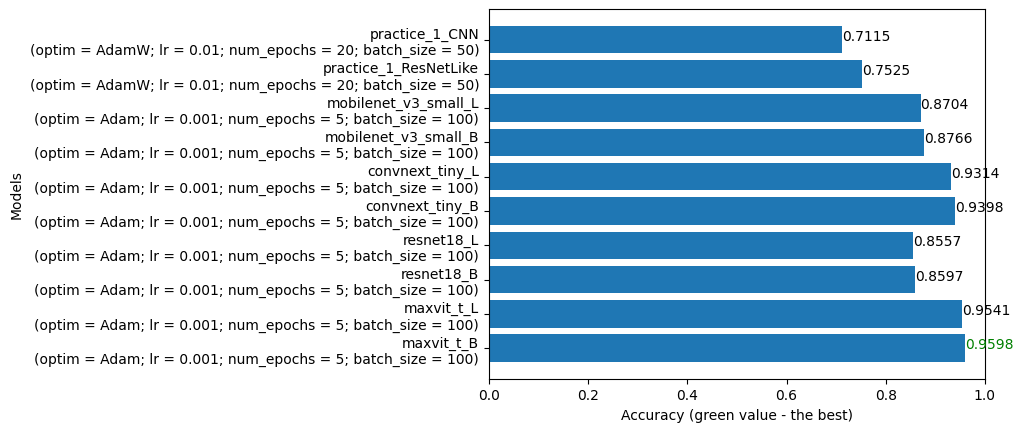

In [134]:
import matplotlib.pyplot as plt
import numpy as np

count_experiments = len(results.keys())
accuracy = [res['acc'] for res in results.values()]
best_acc = max(accuracy)
models = [f'{model}\n({res["params"]})' for (model, res) in results.items()]


plt.xlabel('Accuracy (green value - the best)')
plt.ylabel('Models')
bars = plt.barh(range(count_experiments), accuracy)
for i, bar in enumerate(bars):
    width = bar.get_width()
    label_y = bar.get_y() + bar.get_height() / 2
    color = 'green' if accuracy[i] == best_acc else 'black'
    plt.text(width, label_y, s=f'{accuracy[i]:.4f}', color=color)
plt.yticks(range(count_experiments), models)
plt.xlim([0., 1.])
plt.gca().invert_yaxis()
plt.show()